In [1]:
import dill
import networkx as nx
import pyro.distributions as dist
import matplotlib.pylab as plt
import numpy as np
import sys
sys.path.append("/home/folzd/phd/compositions_mixtures_factors")
from model_operators import *
from utils import *
from code_generation import *
from graph_grammar import *
from models_and_guides import *
from inference import *
from plotting import *
from scipy.stats import gaussian_kde

In [2]:
%load_ext autoreload

%autoreload 2

## Define graph for factor model

In [3]:
factor = nx.DiGraph()

In [4]:
nodes = [
    #('z_loc',{'type':'const', 'value':0.}),
    #('z_scale',{'type':'const', 'value':1.}),
    ('z_loc',{'type':'function', 'function':torch.zeros, 'args':(Name(id='K'),)}),
    ('z_scale',{'type':'function', 'function':torch.ones, 'args':(Name(id='K'),)}),
    ('z',{'distribution':dist.Normal,'type':'latent','event_dims':1}),
    #('z_T',{'type':'deterministic', 'function':torch.transpose, 'args':(Num(0),Num(1))}),
    #('z_T',{'type':'function', 'function':torch.transpose, 'args':(Num(0),Num(1))}),
    ('cov_diag_loc',{'type':'param','shape':'D'}),
    ('cov_diag_scale',{'type':'param','shape':'D','constraint':'positive'}),
#    ('cov_factor_loc',{'type':'param','shape':'KD'}),
#    ('cov_factor_scale',{'type':'param','shape':'KD','constraint':'positive'}),
    ('cov_factor_loc',{'type':'param','shape':'DK'}),
    ('cov_factor_scale',{'type':'param','shape':'DK','constraint':'positive'}),
    ('cov_factor',{'distribution':dist.Normal,'type':'latent','event_dims':2}),
    ('loc_loc',{'type':'param','shape':'D'}),
    ('loc_scale',{'type':'param','shape':'D','constraint':'positive'}),
    ('loc',{'distribution':dist.Normal,'type':'latent','event_dims':1}),
    #('Wz',{'type':'deterministic', 'function':torch.matmul}),
    ('Wz',{'type':'function', 'function':torch.matmul, 'args':('p','t')}),
    ('Wzloc',{'type':'function', 'function':torch.add, 'args':('p','p')}),
    ('X',{'distribution':dist.MultivariateNormal,'type':'obs'}),
    ('cov_diag',{'distribution':dist.LogNormal,'type':'latent','event_dims':1}),
    ('cov_diag_j',{'type':'function', 'function':torch.add, 'args':('p',Num(n=0.0001))}),
    #('diag',{'type':'deterministic', 'function':torch.diag_embed}),
    ('diag',{'type':'function', 'function':torch.diag_embed}),
]

In [5]:
edges = [
    ('cov_diag_loc','cov_diag',{'type':'param','param':'loc'}),
    ('cov_diag_scale','cov_diag',{'type':'param','param':'scale'}),
    ('cov_factor_loc','cov_factor',{'type':'param','param':'loc'}),
    ('cov_factor_scale','cov_factor',{'type':'param','param':'scale'}),
    ('loc_loc','loc',{'type':'param','param':'loc'}),
    ('loc_scale','loc',{'type':'param','param':'scale'}),
    ('z_loc','z',{'type':'param','param':'loc'}),
    ('z_scale','z',{'type':'param','param':'scale'}),    
    #('z','Wz',{'type':'arg', 'transpose':True}),
#    ('z','z_T',{'type':'arg'}),
#    ('z_T','Wz',{'type':'arg'}),
    ('z','Wz',{'type':'arg'}),
    ('cov_factor','Wz',{'type':'arg'}),
    ('Wz','Wzloc',{'type':'arg'}),
    ('loc','Wzloc',{'type':'arg'}),
    ('Wzloc','X',{'type':'param','param':'loc'}),
    #('cov_diag','X',{'type':'param','param':'scale'})
    ('cov_diag','cov_diag_j',{'type':'arg'}),
    ('cov_diag_j','diag',{'type':'arg'}),
    ('diag','X',{'type':'param','param':'covariance_matrix'})
]

In [6]:
plate_attr = {
#    'cov_factor':{'plates':['D','K']},
#    'cov_diag':{'plates':['D']},
    'X':{'plates':['N']},
    'Wz':{'plates':['N']},
    #'z':{'plates':['N','K']},
    'z':{'plates':['N']},
    #'z_T':{'plates':['N']}
}

In [7]:
factor.add_nodes_from(nodes)
factor.add_edges_from(edges)
nx.set_node_attributes(factor, plate_attr)

W: D, K

z: K, N

Sigma: D

Wz: N

X: N

/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


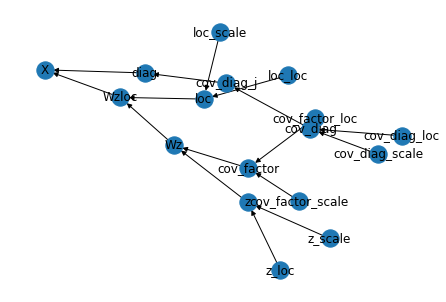

In [8]:
nx.draw(factor, with_labels=True)

## Marginalize latent variables out

In [9]:
marg_factor = marginalize_factor(factor)

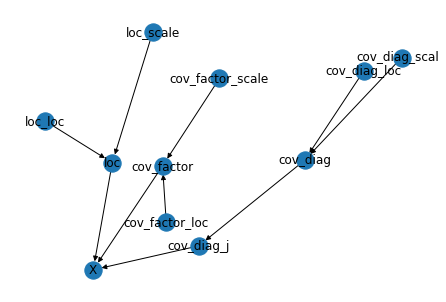

In [10]:
nx.draw(marg_factor, with_labels=True)

### Create graph and code for mixture of factor analyzers

In [11]:
mixture = mixture_from_marg_factor(marg_factor)

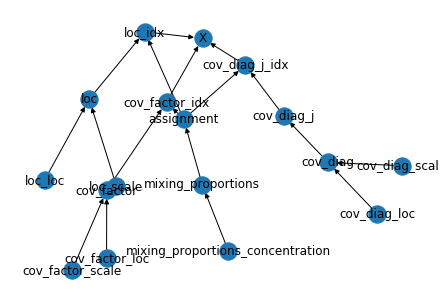

In [12]:
nx.draw(mixture, with_labels=True)

In [13]:
#generate_Model_class(marg_factor)
generate_Model_class(mixture, [marginalize_factor, mixture_from_marg_factor])

Created model mixture_marginalize in model.py


In [14]:
generate_Model_class(marg_factor, [marginalize_factor])

Created model marginalize in model.py


In [15]:
from model import *

In [16]:
from pyro.ops.indexing import Vindex

class mixture_marginalize(Model):
    """
    Template class for code generated from a DAG
    """
    def __init__(self, X, K, C, batch_size, _id):
        self.K = K
        self.C = C
        super(mixture_marginalize, self).__init__(X, batch_size, _id)


    def get_param_shapes_and_support(self, _id=None):
        if _id == None:
            _id = self._id
        return {f'loc_scale_init_{_id}': ((self.C, self.D), constraints.
            positive), f'loc_prior_scale_init_{_id}': ((self.C, self.D),
            constraints.positive), f'loc_loc_init_{_id}': ((self.C, self.D),
            constraints.real), f'loc_prior_loc_init_{_id}': ((self.C, self.D),
            constraints.real), f'mixing_proportions_concentration_init_{_id}':
            ((self.C,), constraints.positive),
            f'mixing_proportions_prior_concentration_init_{_id}': ((self.C,),
            constraints.positive), f'cov_factor_scale_init_{_id}': ((self.C,
            self.D, self.K), constraints.positive),
            f'cov_factor_prior_scale_init_{_id}': ((self.C, self.D, self.K),
            constraints.positive), f'cov_factor_loc_init_{_id}': ((self.C, self
            .D, self.K), constraints.real), f'cov_factor_prior_loc_init_{_id}':
            ((self.C, self.D, self.K), constraints.real),
            f'cov_diag_scale_init_{_id}': ((self.C, self.D), constraints.
            positive), f'cov_diag_prior_scale_init_{_id}': ((self.C, self.D),
            constraints.positive), f'cov_diag_loc_init_{_id}': ((self.C, self.D
            ), constraints.real), f'cov_diag_prior_loc_init_{_id}': ((self.C,
            self.D), constraints.real)}


    def model(self, X):
        C = self.C
        K = self.K
        N, D = X.shape
        _id = self._id
        loc_prior_scale_init = self.param_init[f'loc_prior_scale_init_{_id}']
        loc_prior_scale = pyro.param(f'loc_prior_scale_{_id}',
            loc_prior_scale_init, constraint=constraints.positive)
        loc_prior_loc_init = self.param_init[f'loc_prior_loc_init_{_id}']
        loc_prior_loc = pyro.param(f'loc_prior_loc_{_id}', loc_prior_loc_init)
        with pyro.plate(f'C_{_id}', C):
            loc = pyro.sample(f'loc_{_id}', dist.Normal(loc_prior_loc,
                loc_prior_scale).to_event(1))
            cov_factor_prior_scale_init = self.param_init[
                f'cov_factor_prior_scale_init_{_id}']
            cov_factor_prior_scale = pyro.param(f'cov_factor_prior_scale_{_id}',
                cov_factor_prior_scale_init, constraint=constraints.positive)
            cov_factor_prior_loc_init = self.param_init[
                f'cov_factor_prior_loc_init_{_id}']
            cov_factor_prior_loc = pyro.param(f'cov_factor_prior_loc_{_id}',
                cov_factor_prior_loc_init)
            cov_factor = pyro.sample(f'cov_factor_{_id}', dist.Normal(
                cov_factor_prior_loc, cov_factor_prior_scale).to_event(2))
            cov_diag_prior_scale_init = self.param_init[
                f'cov_diag_prior_scale_init_{_id}']
            cov_diag_prior_scale = pyro.param(f'cov_diag_prior_scale_{_id}',
                cov_diag_prior_scale_init, constraint=constraints.positive)
            cov_diag_prior_loc_init = self.param_init[
                f'cov_diag_prior_loc_init_{_id}']
            cov_diag_prior_loc = pyro.param(f'cov_diag_prior_loc_{_id}',
                cov_diag_prior_loc_init)
            cov_diag = pyro.sample(f'cov_diag_{_id}', dist.LogNormal(
                cov_diag_prior_loc, cov_diag_prior_scale).to_event(1))
            cov_diag_j = torch.add(cov_diag, 0.0001)
        mixing_proportions_prior_concentration_init = self.param_init[
            f'mixing_proportions_prior_concentration_init_{_id}']
        mixing_proportions_prior_concentration = pyro.param(
            f'mixing_proportions_prior_concentration_{_id}',
            mixing_proportions_prior_concentration_init, constraint=constraints
            .positive)
        mixing_proportions = pyro.sample(f'mixing_proportions_{_id}', dist.
            Dirichlet(mixing_proportions_prior_concentration))
        with pyro.plate(f'N_{_id}', N, subsample_size=self.batch_size) as ind:
            assignment = pyro.sample(f'assignment_{_id}', dist.Categorical(
                mixing_proportions), infer={'enumerate': 'parallel'})

            #loc_idx = loc[assignment]
            #cov_diag_j_idx = cov_diag_j[assignment]
            #cov_factor_idx = cov_factor[assignment]
            loc_idx = Vindex(loc)[...,assignment,:]
            cov_diag_j_idx = Vindex(cov_diag_j)[...,assignment,:]
            cov_factor_idx = Vindex(cov_factor)[...,assignment,:,:]
            X = pyro.sample('obs', dist.LowRankMultivariateNormal(loc_idx,
                cov_factor_idx, cov_diag_j_idx), obs=X.index_select(0, ind))
        return X


    def guide(self, X):
        C = self.C
        K = self.K
        N, D = X.shape
        _id = self._id
        loc_scale_init = self.param_init[f'loc_scale_init_{_id}']
        loc_scale = pyro.param(f'loc_scale_{_id}', loc_scale_init, constraint=
            constraints.positive)
        loc_loc_init = self.param_init[f'loc_loc_init_{_id}']
        loc_loc = pyro.param(f'loc_loc_{_id}', loc_loc_init)
        with pyro.plate(f'C_{_id}', C):
            loc = pyro.sample(f'loc_{_id}', dist.Normal(loc_loc, loc_scale).
                to_event(1))
            cov_factor_scale_init = self.param_init[f'cov_factor_scale_init_{_id}']
            cov_factor_scale = pyro.param(f'cov_factor_scale_{_id}',
                cov_factor_scale_init, constraint=constraints.positive)
            cov_factor_loc_init = self.param_init[f'cov_factor_loc_init_{_id}']
            cov_factor_loc = pyro.param(f'cov_factor_loc_{_id}',
                cov_factor_loc_init)
            cov_factor = pyro.sample(f'cov_factor_{_id}', dist.Normal(
                cov_factor_loc, cov_factor_scale).to_event(2))
            cov_diag_scale_init = self.param_init[f'cov_diag_scale_init_{_id}']
            cov_diag_scale = pyro.param(f'cov_diag_scale_{_id}',
                cov_diag_scale_init, constraint=constraints.positive)
            cov_diag_loc_init = self.param_init[f'cov_diag_loc_init_{_id}']
            cov_diag_loc = pyro.param(f'cov_diag_loc_{_id}', cov_diag_loc_init)
            cov_diag = pyro.sample(f'cov_diag_{_id}', dist.LogNormal(
                cov_diag_loc, cov_diag_scale).to_event(1))
            cov_diag_j = torch.add(cov_diag, 0.0001)
        mixing_proportions_concentration_init = self.param_init[
            f'mixing_proportions_concentration_init_{_id}']
        mixing_proportions_concentration = pyro.param(
            f'mixing_proportions_concentration_{_id}',
            mixing_proportions_concentration_init, constraint=constraints.positive)
        mixing_proportions = pyro.sample(f'mixing_proportions_{_id}', dist.
            Dirichlet(mixing_proportions_concentration))
        return cov_factor, cov_diag, loc, mixing_proportions


In [17]:
pyro.clear_param_store()
N = 5000
D = 2
K = 2
C = 5
dagmodel = mixture_marginalize(torch.zeros(N,D),K,C,N,'id')
tmp = dagmodel.model(torch.zeros(N,D))

In [18]:
dagmodel.param_shapes_and_support

{'loc_scale_init_id': ((5, 2), GreaterThan(lower_bound=0.0)),
 'loc_prior_scale_init_id': ((5, 2), GreaterThan(lower_bound=0.0)),
 'loc_loc_init_id': ((5, 2), Real()),
 'loc_prior_loc_init_id': ((5, 2), Real()),
 'mixing_proportions_concentration_init_id': ((5,),
  GreaterThan(lower_bound=0.0)),
 'mixing_proportions_prior_concentration_init_id': ((5,),
  GreaterThan(lower_bound=0.0)),
 'cov_factor_scale_init_id': ((5, 2, 2), GreaterThan(lower_bound=0.0)),
 'cov_factor_prior_scale_init_id': ((5, 2, 2), GreaterThan(lower_bound=0.0)),
 'cov_factor_loc_init_id': ((5, 2, 2), Real()),
 'cov_factor_prior_loc_init_id': ((5, 2, 2), Real()),
 'cov_diag_scale_init_id': ((5, 2), GreaterThan(lower_bound=0.0)),
 'cov_diag_prior_scale_init_id': ((5, 2), GreaterThan(lower_bound=0.0)),
 'cov_diag_loc_init_id': ((5, 2), Real()),
 'cov_diag_prior_loc_init_id': ((5, 2), Real())}

In [19]:
pyro.set_rng_seed(42)

In [20]:
dgp = dagmodel.unconditioned_model
trace = pyro.poutine.trace(dgp).get_trace(torch.empty(N,D))
true_variables = dict([(name,trace.nodes[name]["value"]) for name in trace.stochastic_nodes if len(name)>1])
true_locs = true_variables['loc_id']*20

new_dgp = pyro.poutine.condition(dgp, data={'loc_id':true_locs})
trace = pyro.poutine.trace(new_dgp).get_trace(torch.empty(N,D))

true_variables = dict([(name,trace.nodes[name]["value"]) for name in trace.stochastic_nodes if len(name)>1])
X = true_variables['obs'].detach()
Xz = torch.cat([X,true_variables['assignment_id'].detach().float().unsqueeze(-1)],dim=-1)
Xzdata, Xztest_data = train_test_split(Xz)
data, train_assign = Xzdata[:,:-1],Xzdata[:,-1]
test_data, test_assign = Xztest_data[:,:-1],Xztest_data[:,-1]

In [21]:
X.shape

torch.Size([5000, 2])

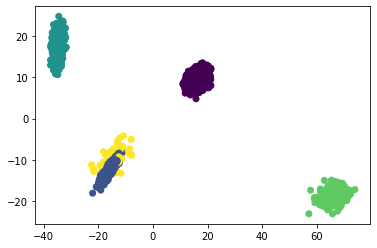

In [22]:
rand_idx = np.random.choice(D,2, replace=False)

rand_idx

plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
#plt.scatter(*foo['obs'][:,0,0,rand_idx].squeeze().T.detach())

## Make random split

In [23]:
def split_along_eigvector(mean, cov):
    eigvals, eigvecs = torch.eig(cov, eigenvectors=True)
    # cov = M @ M.T
    # where M = eigvecs @ torch.diag(torch.sqrt(eigvals[:,0]))
    weighted_eigvecs = torch.matmul(torch.diag(torch.sqrt(eigvals[:,0])),eigvecs.T)
    # sample eigevector with probability proportional to eigenvalue
    softmax = torch.nn.Softmax(dim=0)
    v = np.random.choice(eigvals.shape[0],p=softmax(torch.abs(eigvals[:,0])).numpy())
    vec = weighted_eigvecs[v]
    eigvals0 = eigvals.clone()
    eigvals0[v,0] = eigvals0[v,0]/2
    # shift means by weighted eigenvector
    # scale factor by 1/2
    return torch.stack([mean+vec,mean-vec]), torch.matmul(eigvecs,torch.diag(torch.sqrt(eigvals0[:,0])))

In [24]:
def get_cov(variance_loc_param, variance_scale_param, cov_factor_param):
    variances_mean = torch.exp(variance_loc_param+variance_scale_param**2/2)
    cov = torch.matmul(cov_factor_param,cov_factor_param.T) + torch.diag(variances_mean)
    return cov

In [25]:
def cov_mat(model, c=None):
    if c == None:
        # return all covmats
        cs = np.arange(model.params['mixing_proportions_concentration_'+model._id].shape[0])
    else:
        cs = [c]
    covs = []
    for c in cs:
        cov = get_cov(model.params['cov_diag_loc_'+model._id][c],model.params['cov_diag_scale_'+model._id][c],model.params['cov_factor_loc_'+model._id][c])
        covs.append(cov)
    return covs

In [26]:
def init_split_move(student, teacher, split_cluster_idx):
    """
    Replaces all tensors in student.param_init by those in teacher.params,
    except for those that define the splitted cluster, which are split_along_eigvector
    """
    c = split_cluster_idx
    
    if type(teacher) == marginalize:
        mean = teacher.params['loc_loc_'+teacher._id]
        cov = get_cov(teacher.params['cov_diag_loc_'+teacher._id],teacher.params['cov_diag_scale_'+teacher._id],teacher.params['cov_factor_loc_'+teacher._id])
        teacher.params['mixing_proportions_concentration_'+teacher._id] = torch.ones(1)
        teacher.params['mixing_proportions_prior_concentration_'+teacher._id] = torch.ones(1)
    else:
        mean = teacher.params['loc_loc_'+teacher._id][c]
        cov = cov_mat(teacher, c=split_cluster_idx)[0]
        teacher_mixing = 'mixing_proportions_concentration_'+teacher._id
    
    new_means, new_cov_factor = split_along_eigvector(mean, cov)    
    
    for param_name, param_value in student.param_init.items():
        teacher_param_name = param_name.replace('init_'+student._id, teacher._id)
        if teacher_param_name not in teacher.params.keys():
            print(teacher_param_name)
        teacher_mixing = 'mixing_proportions_concentration_'+teacher._id
        for component,_ in enumerate(teacher.params[teacher_param_name]):
            if component == c:
                student.param_init['loc_loc_init_'+student._id][component] = new_means[0]
                student.param_init['loc_loc_init_'+student._id][-1] = new_means[1]
                student.param_init['loc_prior_loc_init_'+student._id][component] = new_means[0]
                student.param_init['loc_prior_loc_init_'+student._id][-1] = new_means[1]

                student.param_init['cov_factor_loc_init_'+student._id][component] = new_cov_factor
                student.param_init['cov_factor_loc_init_'+student._id][-1] = new_cov_factor
                student.param_init['cov_factor_prior_loc_init_'+student._id][component] = new_cov_factor
                student.param_init['cov_factor_prior_loc_init_'+student._id][-1] = new_cov_factor
                
                student.param_init['mixing_proportions_concentration_init_'+student._id][component] = teacher.params[teacher_mixing][component]/2
                student.param_init['mixing_proportions_concentration_init_'+student._id][-1] = teacher.params[teacher_mixing][component]/2
                next
            else:
                student.param_init[param_name][component] = teacher.params[teacher_param_name][component]
    return mean, cov, new_means, new_cov_factor

In [27]:
# new criterion:
# empirical KL divergence
# E_q[log(q/p)]
# where q is the empirical distribution
# and p is the component distribution

In [28]:
def compute_assignments(data, posterior_samples, _id):
    if _id is None:
        _id = list(posterior_samples.keys())[0].split('_')[-1]
    n_posterior_samples,C,D = posterior_samples['loc_'+_id].shape
    #n_posterior_samples = 200
    # get component distributions
    components = dist.LowRankMultivariateNormal(posterior_samples['loc_'+_id][:n_posterior_samples],posterior_samples['cov_factor_'+_id][:n_posterior_samples],posterior_samples['cov_diag_'+_id][:n_posterior_samples])
    # find log_prob of every datapoint under each component, for all posterior samples
    responsibilities = components.log_prob(data.unsqueeze(-2).unsqueeze(-2))
    greatest_responsibility,most_responsible = responsibilities.max(dim=-1)

    assignment = []
    for votes in most_responsible:
        vote, counts = torch.unique(votes, return_counts = True)
        assignment.append(int(vote[counts.argmax()]))

    return np.array(assignment)

In [29]:
def KLpq(data, cluster, components, assignments):
    """
    Divergence from mixture component distribution (q)
    to Kernel Density Estimate of component (p)
    """
    data_assigned_to_cluster = data[assignments == cluster]
    n,d = data.shape
    kde = gaussian_kde(data_assigned_to_cluster.T, bw_method=n**(-1./(d+4))/d)
    p_logpdf = np.array([kde.logpdf(data_assigned_to_cluster[i]) for i in range(len(data_assigned_to_cluster))]).squeeze()
    q_logpdf = torch.tensor([components.log_prob(data_assigned_to_cluster[i]).mean(0)[cluster] for i in range(len(data_assigned_to_cluster))])
    return (np.exp(p_logpdf)*(p_logpdf-q_logpdf.numpy())).sum()

In [30]:
def split_move(teacher, _id):
    pyro.clear_param_store()
    if type(teacher) == marginalize:
        C = 2
        split_cluster = 0
    else:
        C = teacher.C
        # sample cluster to be split
        # probabilities prop to cluster size?
        # probs prop to covmat_trace/mixing_weight? (split clusters that are large compared to how many points they contain)
        # probs = torch.stack([cov.trace() for cov in cov_mat(teacher)])/teacher.params['mixing_proportions_concentration_'+teacher._id]
        teacher.sample_posterior_predictive(data.shape[0])
        teacher.batch_size = 1
        teacher_ppc = teacher.posterior_predictive(data)
        _id = teacher._id
        assignments = compute_assignments(data, teacher_ppc, _id)
        components = dist.LowRankMultivariateNormal(teacher_ppc['loc_'+_id],teacher_ppc['cov_factor_'+_id],teacher_ppc['cov_diag_'+_id])
        probs = torch.tensor([KLpq(data, cluster, components, assignments) for cluster in range(C)])
        softmax = torch.nn.Softmax(dim = 0)
        #probs = probs/probs.sum()
        probs = softmax(probs).numpy()
        split_cluster = np.random.choice(teacher.C,p=probs)
        C = teacher.C + 1
    student = mixture_marginalize(torch.zeros(N,D),K,C,N,_id)
    foo = init_split_move(student, teacher, split_cluster)
    config['n_iter'] = 1
    config['telemetry'] = None
    inference(student, data, test_data, config=config)
    return student, foo

In [31]:
n_iter = 1000
config = dict(
        n_iter = n_iter,
        learning_rate = 0.08, 
        beta1 = 0.9,
        beta2 = 0.999,
        learning_rate_decay = 1., # no decay by default
        batch_size = 32, 
        n_elbo_particles = 32, 
        n_posterior_samples = 1024,
        window = 50,
        convergence_window = 10,
        slope_significance = 0.99,
        track_params = True,
        monitor_gradients = False,
        telemetry = None
    )

pyro.clear_param_store()
N,D = data.shape
K = 2
C = 2
split_count = 0
student = marginalize(data, 2, 32, 'split_0')
telemetry = inference(student, data, test_data, config=config)
MNLL = 1e10
new_MNLL = telemetry['MNLL'][-1]
while MNLL/new_MNLL > 1.001: 
    split_count += 1
    print(split_count)
    teacher = student
    student, _ = split_move(teacher, 'split_'+str(split_count))
    config['n_iter'] = n_iter
    config['telemetry'] = telemetry
    telemetry = inference(student, data, test_data, config=config)
    MNLL = new_MNLL
    new_MNLL = telemetry['MNLL'][-1]



NLL after 0/1000 iterations is 37.7818603515625
....................................................................................................

NLL after 100/1000 iterations is 10.437751770019531


.................................................

NLL after 150/1000 iterations is 9.647025108337402


.................................................

NLL after 200/1000 iterations is 9.409064292907715


.................................................

NLL after 250/1000 iterations is 9.284811973571777


.................................................

NLL after 300/1000 iterations is 9.296917915344238


.................................................

NLL after 350/1000 iterations is 9.222557067871094


.................................................

NLL after 400/1000 iterations is 9.26545524597168


.................................................

NLL after 450/1000 iterations is 9.284183502197266


.................................................

NLL after 500/10

AssertionError: 

In [ ]:
%debug

In [ ]:
telemetry.keys()

In [ ]:
telemetry['param_history']

In [ ]:
param_store = pyro.get_param_store()

In [ ]:
telemetry['param_store_state']

In [ ]:
param_store.set_state

In [ ]:
c = 1
for i in range(split_count):
    pyro.clear_param_store()
    first_iter = {param:values[0] for param,values in telemetry['param_history'].items() if param.endswith(str(i))}
    last_iter = {param:values[-1] for param,values in telemetry['param_history'].items() if param.endswith(str(i))}
    
    if i == 0: 
        history1 = marginalize(data, 2, 32, 'h1')
        history2 = marginalize(data, 2, 32, 'h2')
    else:
        history1 = mixture_marginalize(torch.zeros(N,D),K,i+1,N,'h1')
        history2 = mixture_marginalize(torch.zeros(N,D),K,i+1,N,'h2')
    
    # set params to historical ones
    for param,value in first_iter.items():
        pyro.param(param[:-7]+'h1', value)
    for param,value in last_iter.items():
        pyro.param(param[:-7]+'h2', value)
    # sample posterior predictive
    history1.sample_posterior_predictive(data.shape[0])
    history1.batch_size = 1
    history1_ppc = history1.posterior_predictive(data)
    history1.batch_size = 32
    # plot
    #plt.subplot(4,2,c)
    plt.figure()
    plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
    plt.scatter(*history1_ppc['obs'][:,0,rand_idx].squeeze().T.detach(),alpha=.1)
    c += 1
    
    # sample posterior predictive
    history2.sample_posterior_predictive(data.shape[0])
    history2.batch_size = 1
    history2_ppc = history2.posterior_predictive(data)
    history2.batch_size = 32
    # plot
    #plt.subplot(4,2,c)
    plt.figure()
    plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
    plt.scatter(*history2_ppc['obs'][:,0,rand_idx].squeeze().T.detach(),alpha=.1)
    c += 1

In [ ]:
len(telemetry['loss'])

In [ ]:
MNLL

In [ ]:
new_MNLL

In [ ]:
MNLL/new_MNLL

In [ ]:
teacher.sample_posterior_predictive(data.shape[0])

teacher.batch_size = 1
teacher_ppc = teacher.posterior_predictive(data)
teacher.batch_size = 32

In [ ]:
student.sample_posterior_predictive(data.shape[0])

student.batch_size = 1
student_ppc = student.posterior_predictive(data)
student.batch_size = 32

In [ ]:
%matplotlib qt
plt.plot(telemetry['MNLL'])

#### Plot color-coded true data against predictive posterior sample

In [ ]:
%matplotlib qt
#plt.scatter(*data[:,rand_idx].T)
plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
#plt.scatter(*student_ppc['obs'][:,0,rand_idx].squeeze().T.detach(),alpha=.1)
plt.scatter(*teacher_ppc['obs'][:,0,rand_idx].squeeze().T.detach(),alpha=.1)

In [ ]:
plt.figure()
plt.scatter(*data[assignments == 2].T)

In [ ]:
cluster = 1
data_assigned_to_cluster = data[assignments == cluster]

In [ ]:
kde = gaussian_kde(data_assigned_to_cluster.T)

In [ ]:
#point = 1000
point = 340

In [ ]:
plt.figure()
plt.scatter(*data[assignments == 1].T)
plt.scatter(*data[assignments == 1][point].T)

In [ ]:
KLpq(data, 0, components, assignments)

In [ ]:
KLpq(data, 1, components, assignments)

In [ ]:
KLpq(data, 2, components, assignments)

In [ ]:
plt.figure()
#plt.scatter(*data[:,rand_idx].T)
plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
plt.figure()
plt.scatter(*data[:,rand_idx].T,c=compute_assignments(data, teacher_ppc, 'split_4'))
#plt.scatter(*teacher_ppc['obs'][:,0,rand_idx].squeeze().T.detach(),alpha=.1)

In [ ]:
student_ppc

#### Plot color-coded predictive posterior sample

In [ ]:
plt.figure()
plt.scatter(*student_ppc['obs'][:,0,rand_idx].squeeze().T.detach(),c=student_ppc['assignment_'+student._id][:,0].squeeze().T.detach())

In [ ]:
plt.figure()
plt.scatter(*data[:,rand_idx].T)
plt.scatter(*teacher_ppc['obs'][:,0,rand_idx].squeeze().T.detach(),c=teacher_ppc['assignment_'+teacher._id][:,0].squeeze().T.detach())

In [ ]:
teacher.params

#### Plot true data color-coded by predictive posterior sample

In [ ]:
plt.scatter(*data[:,rand_idx].T,c=compute_assignments(data, student_ppc))

In [ ]:
mean, cov, new_means, new_cov_factor = foo
ax = plt.axes()
plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
#plt.scatter(x,y)
plt.xlim(-30,50)
plt.ylim(-140,140)
confidence_ellipse(mean,cov,ax,3.0,'b',alpha=.5)
confidence_ellipse(new_means[0],new_cov_factor@new_cov_factor.T,ax,3.0,'r',alpha=.5)
confidence_ellipse(new_means[1],new_cov_factor@new_cov_factor.T,ax,3.0,'r',alpha=.5)
#confidence_ellipse(student.params['loc_loc_id'][c].numpy(),np.cov(x,y),ax,3.0,'r',alpha=.5)
#ax.arrow(*student.params['loc_loc_id'][c], *weighted_eigvecs[0], head_width=0.5, head_length=0.7, fc='lightblue', ec='black')
#ax.arrow(*student.params['loc_loc_id'][c], *weighted_eigvecs[1], head_width=0.5, head_length=0.7, fc='lightblue', ec='black')